In [1]:
%load_ext autoreload
%autoreload 2
from Methods import JobOffers,dataframeHelpers

In [2]:
import os
import nltk
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [3]:
autoreload JobOffers,dataframeHelpers

In [4]:
# Only run this if you want to redo the translations
# Start with google and use easynmt if it fails
# JobOffers.writeTranslatedJobs(1000, method="google", fallback=True)

In [5]:
# rawOffers = JobOffers.readJsonFile("Data/output_v1.1.json")

In [6]:
mergedDf = pd.read_csv("Data/mergedJobs1000.csv")

In [7]:
len(mergedDf)

1101

In [8]:
for canton in mergedDf["CANTON1"].value_counts().index[:-1]:
    mergedDf[f"Canton_{canton}"] = mergedDf.apply(lambda x: canton in x["CANTON"], axis=1)

In [9]:
dummies = pd.get_dummies(mergedDf["COMPANY_SIZE"])
mergedDf = mergedDf.join(dummies)

In [10]:
mergedDf["MJ"].value_counts()

1.0    304
0.0    237
Name: MJ, dtype: int64

In [11]:
mergedDf.iloc[0]["TRANSLATED_JOBS"]

'Building leaders Horticultural technician HF The Aemmer AG has been preparing sophisticated and beautiful garden and sports facilities for over 85 years. As a traditional family business with 35 employees and the most modern machinery, we strive to afford proper work. For expanding our team, we are looking for immediate or after agreement building guideline horticultural technician HF their area of \u200b\u200bresponsibility they are involved in the entire expiration of the planning offensea before and construction management to billing. Your areas of responsibility include sophisticated new plant garden change in private and public areas. Our expectations independence as well as joy in working in a team. In addition to flexibility of versatility and commitment should, above all, enjoy the contact with our customers. We offer we offer you a challenging versatile and self-employed activity of a modern dynamic and family operation. A pleasant working atmosphere in a motivated team and a

In [12]:
labeledDf = mergedDf[~mergedDf["MJ"].isna()]

In [13]:
labeledDf

,Unnamed: 0,index,JOB_ID,MJ,ISCO,JOB_CONTENT,TRANSLATED_JOBS,CANTON,COMPANY_SIZE,NumSentences,...,Canton_GE,Canton_NE,Canton_FR,Canton_VS,Canton_JU,Canton_AR,Large,Micro,Midsize,Small
0,0,0,12047533.0,1.0,31230;12190;21620,['Building leaders Horticultural technician HF...,Building leaders Horticultural technician HF T...,['BE'],Micro,25,...,False,False,False,False,False,False,0,1,0,0
1,1,1,14422389.0,1.0,21620,['As an educational and social education cente...,"As an educational and social education center,...",['BE'],Small,15,...,False,False,False,False,False,False,0,0,0,1
2,2,2,14616465.0,1.0,21420,['Civil Engineer 1804 Corsiersurvey Engineerin...,Civil Engineer 1804 Corsiersurvey Engineering ...,['VD'],Micro,12,...,False,False,False,False,False,False,0,1,0,0
3,3,3,14617343.0,1.0,21620,"['24', ' 05', ' 2017 Internship Landscape Deve...",24. 05. 2017 Internship Landscape Development ...,['BE'],Micro,7,...,False,False,False,False,False,False,0,1,0,0
4,4,4,14515774.0,1.0,21430,['Company portrait The office for the forest o...,Company portrait The office for the forest of ...,['BE'],Midsize,21,...,False,False,False,False,False,False,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,1120,120,20933760.0,1.0,24310;24210,"[""Emploi ESDA is looking for a Market Data Ana...",Emploi ESDA is looking for a Market Data Analy...,['GE'],Midsize,12,...,True,False,False,False,False,False,0,0,1,0
1097,1121,121,21930428.0,1.0,26220;41200,"['Org', ' Setting and Reporting This position...",Org. Setting and Reporting This position is l...,['GE'],Midsize,66,...,True,False,False,False,False,False,0,0,1,0
1098,1122,122,22071257.0,1.0,26220,['Caterpillar Graduate Program Junior Busines...,Caterpillar Graduate Program Junior Business ...,['GE'],Large,21,...,True,False,False,False,False,False,1,0,0,0
1099,1123,123,18359929.0,1.0,21490,"['Energy Energy Management Raymond E', ' Moser...",Energy Energy Management Raymond E. Moser has ...,['GE'],Micro,24,...,True,False,False,False,False,False,0,1,0,0


In [14]:
mergedDf

,Unnamed: 0,index,JOB_ID,MJ,ISCO,JOB_CONTENT,TRANSLATED_JOBS,CANTON,COMPANY_SIZE,NumSentences,...,Canton_GE,Canton_NE,Canton_FR,Canton_VS,Canton_JU,Canton_AR,Large,Micro,Midsize,Small
0,0,0,12047533.0,1.0,31230;12190;21620,['Building leaders Horticultural technician HF...,Building leaders Horticultural technician HF T...,['BE'],Micro,25,...,False,False,False,False,False,False,0,1,0,0
1,1,1,14422389.0,1.0,21620,['As an educational and social education cente...,"As an educational and social education center,...",['BE'],Small,15,...,False,False,False,False,False,False,0,0,0,1
2,2,2,14616465.0,1.0,21420,['Civil Engineer 1804 Corsiersurvey Engineerin...,Civil Engineer 1804 Corsiersurvey Engineering ...,['VD'],Micro,12,...,False,False,False,False,False,False,0,1,0,0
3,3,3,14617343.0,1.0,21620,"['24', ' 05', ' 2017 Internship Landscape Deve...",24. 05. 2017 Internship Landscape Development ...,['BE'],Micro,7,...,False,False,False,False,False,False,0,1,0,0
4,4,4,14515774.0,1.0,21430,['Company portrait The office for the forest o...,Company portrait The office for the forest of ...,['BE'],Midsize,21,...,False,False,False,False,False,False,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,1120,120,20933760.0,1.0,24310;24210,"[""Emploi ESDA is looking for a Market Data Ana...",Emploi ESDA is looking for a Market Data Analy...,['GE'],Midsize,12,...,True,False,False,False,False,False,0,0,1,0
1097,1121,121,21930428.0,1.0,26220;41200,"['Org', ' Setting and Reporting This position...",Org. Setting and Reporting This position is l...,['GE'],Midsize,66,...,True,False,False,False,False,False,0,0,1,0
1098,1122,122,22071257.0,1.0,26220,['Caterpillar Graduate Program Junior Busines...,Caterpillar Graduate Program Junior Business ...,['GE'],Large,21,...,True,False,False,False,False,False,1,0,0,0
1099,1123,123,18359929.0,1.0,21490,"['Energy Energy Management Raymond E', ' Moser...",Energy Energy Management Raymond E. Moser has ...,['GE'],Micro,24,...,True,False,False,False,False,False,0,1,0,0


In [15]:
labeledDf["MJ"].astype('bool').value_counts()

True     304
False    237
Name: MJ, dtype: int64

In [16]:
# Only take 2/3 of the "not green" jobs so you have a balanced data set
trainDf = labeledDf[labeledDf.index % 3 != 0]

In [17]:
testDf = labeledDf[labeledDf.index % 3 == 0]

In [18]:
from tensorflow.keras.utils import plot_model

In [19]:
def buildInputs(df):
    normSent = (df["NumSentences"]-df["NumSentences"].mean())/df["NumSentences"].std()
    normChar = (df["NumCharacters"]-df["NumCharacters"].mean())/df["NumCharacters"].std()
    return (df["TRANSLATED_JOBS"].to_numpy(), np.stack(
            (
                normSent, 
                normChar,
                df["Canton_BE"],
                df["Canton_VD"],
                df["Canton_NE"],
                df["Canton_FR"], 
                df["Canton_GE"],
                df["Canton_VS"],
                df["Canton_JU"],
                df["Large"],
                df["Micro"], 
                df["Midsize"],
                df["Small"],
            ), axis=-1))

In [20]:
trainInputs = buildInputs(trainDf)
tf.keras.backend.clear_session()

In [21]:
paragraphInput = tf.keras.layers.Input(shape=(), name="Input", dtype=tf.string)
paragraphEncode = hub.KerasLayer('universal-sentence-encoder_4',
                        input_shape=[], 
                        dtype=tf.string, 
                        trainable=True)(paragraphInput)


In [22]:
paragraphDense = tf.keras.layers.Dense(256, activation='relu')(paragraphEncode)

In [23]:
otherInput = tf.keras.layers.Input(shape=(trainInputs[1].shape[1],))
otherDense = tf.keras.layers.Dense(16,)(otherInput)
mergedLayer = tf.keras.layers.Concatenate()([otherDense, paragraphDense])
denseMerged = tf.keras.layers.Dense(32, activation='relu')(mergedLayer)
output = tf.keras.layers.Dense(1, activation='sigmoid')(denseMerged)

In [24]:
model = tf.keras.Model(inputs=[paragraphInput, otherInput], outputs=output)
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [25]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [26]:
trainDf["MJ"].value_counts()

1.0    204
0.0    157
Name: MJ, dtype: int64

In [27]:
model.fit(x=buildInputs(trainDf), 
          y=trainDf["MJ"].astype("bool"), 
          validation_data=(buildInputs(testDf), testDf["MJ"].astype("bool")),
          callbacks=[callback],
          epochs=3)

Epoch 1/3
12/12 [==============================] - 27s 2s/step - loss: 0.6732 - accuracy: 0.5983 - val_loss: 0.6315 - val_accuracy: 0.6556
Epoch 2/3
12/12 [==============================] - 19s 2s/step - loss: 0.5932 - accuracy: 0.7202 - val_loss: 0.5727 - val_accuracy: 0.6944
Epoch 3/3
12/12 [==============================] - 19s 2s/step - loss: 0.4513 - accuracy: 0.8227 - val_loss: 0.4695 - val_accuracy: 0.7611


In [28]:
testDf["GREEN_PREDICT_FULL"] = model.predict(x=buildInputs(testDf)) > 0.5

<ipython-input-28-6adb286e861b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testDf["GREEN_PREDICT_FULL"] = model.predict(x=buildInputs(testDf)) > 0.5


In [29]:
confusion = pd.crosstab(testDf["MJ"].astype('bool'), testDf["GREEN_PREDICT_FULL"], rownames=['Actual'], colnames=['Predicted'], )
confusion

Predicted,False,True
Actual,,
False,48,32
True,11,89


In [49]:
import seaborn as sn
sn.set(font_scale=1.4)

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

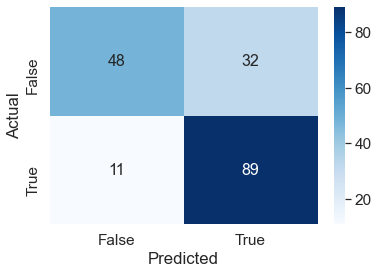

In [50]:
sn.heatmap(confusion, annot=True, cmap="Blues", annot_kws={"size": 16})

In [32]:
plot_model(model, to_file='Plots/NeuralNetArch_AllInputs.pdf', show_shapes=True, show_layer_names=True)

In [33]:
trainDf["MJ"].astype('bool').value_counts()

True     204
False    157
Name: MJ, dtype: int64

In [34]:
denseUnmerged = tf.keras.layers.Dense(32, activation='relu')(paragraphDense)
outputUnmerged = tf.keras.layers.Dense(1, activation='sigmoid')(denseUnmerged)

In [35]:
simpleModel = tf.keras.Model(inputs=[paragraphInput], outputs=outputUnmerged)
simpleModel.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [36]:
trainDf["MJ"].astype('bool').value_counts()

True     204
False    157
Name: MJ, dtype: int64

In [37]:
tf.keras.backend.clear_session()
simpleModel.fit(x=[trainDf["TRANSLATED_JOBS"]], 
          y=trainDf["MJ"].astype('bool'), 
          callbacks=[callback],
          validation_data=([testDf["TRANSLATED_JOBS"]], testDf["MJ"].astype('bool'), ),
          epochs=3)

Epoch 1/3
12/12 [==============================] - 25s 2s/step - loss: 0.4815 - accuracy: 0.8615 - val_loss: 0.4936 - val_accuracy: 0.7500
Epoch 2/3
12/12 [==============================] - 19s 2s/step - loss: 0.2264 - accuracy: 0.9363 - val_loss: 0.5275 - val_accuracy: 0.7556
Epoch 3/3
12/12 [==============================] - 19s 2s/step - loss: 0.0888 - accuracy: 0.9778 - val_loss: 0.5099 - val_accuracy: 0.8056


In [38]:
plot_model(simpleModel, to_file='Plots/NeuralNetArch_OnlySentences.pdf', show_shapes=True, show_layer_names=True)

In [39]:
testDf["GREEN_PREDICT_SIMPLE"] = simpleModel.predict(x=[testDf["TRANSLATED_JOBS"]]) > 0.5
confusionSimple = pd.crosstab(testDf["MJ"].astype('bool'), testDf["GREEN_PREDICT_FULL"], rownames=['Actual'], colnames=['Predicted'], )


<ipython-input-39-051f38d27ca8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testDf["GREEN_PREDICT_SIMPLE"] = simpleModel.predict(x=[testDf["TRANSLATED_JOBS"]]) > 0.5


In [40]:
confusionSimple 

Predicted,False,True
Actual,,
False,48,32
True,11,89


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

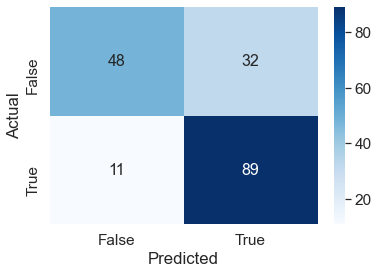

In [51]:
sn.heatmap(confusion, annot=True, cmap="Blues", annot_kws={"size": 16})

In [42]:
mergedDf[mergedDf["TRANSLATED_JOBS"].isna()]

,Unnamed: 0,index,JOB_ID,MJ,ISCO,JOB_CONTENT,TRANSLATED_JOBS,CANTON,COMPANY_SIZE,NumSentences,...,Canton_GE,Canton_NE,Canton_FR,Canton_VS,Canton_JU,Canton_AR,Large,Micro,Midsize,Small


In [43]:
mergedDf["GREEN_PREDICT_SIMPLE"] = simpleModel.predict(x=[mergedDf["TRANSLATED_JOBS"]])

In [44]:
mergedDf["GREEN_PREDICT_FULL"] = model.predict(x=buildInputs(mergedDf))

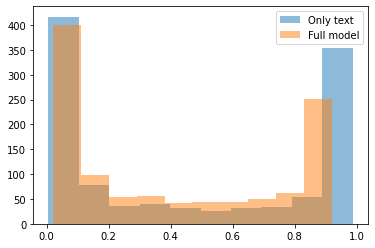

In [45]:
plt.hist(mergedDf["GREEN_PREDICT_SIMPLE"], label="Only text", alpha=0.5)
plt.hist(mergedDf["GREEN_PREDICT_FULL"], label="Full model", alpha=0.5)
plt.legend()